# Vectorisation Tf Idf et classification avec LinearSVC

In [1]:
from common.text_classification_utils import *

dataset = load_dataset()

dataset

,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,zrkrwmgseetfegaozv kovx vh,0,0,0,1
1,Comment puis-je me rendre de l'aéroport de CHA...,1,0,0,0
2,4f3;S0`HsL# hL8ydlwlM2cK7=,0,0,0,1
3,"u*]P\UsbAr,CoDnDdr*-GKN(0O",0,0,0,1
4,J'aimerais connaître le chemin pour aller de S...,1,0,0,0
...,...,...,...,...,...
1302960,Il a prétendu être mon ami.,0,0,1,0
1302961,I am planning a trip from saint paul les dax t...,0,1,0,0
1302962,Go from the train station of Loches to Venarey...,0,1,0,0
1302963,Je souhaiterais aller à verneuil sur serre dep...,1,0,0,0


In [2]:
labels, id2label, label2id = prepare_labels(dataset)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


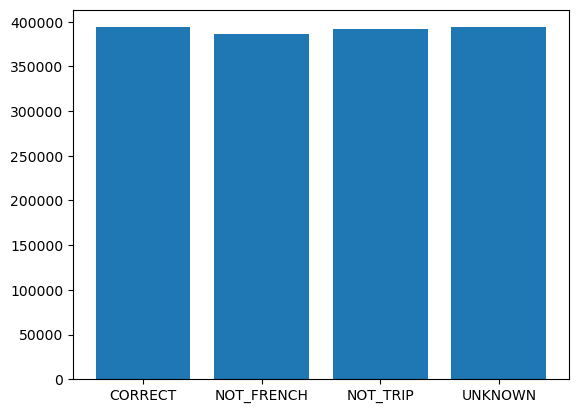

In [3]:
show_labels_distribution(dataset, labels)

# Split du dataset en train, test et validation

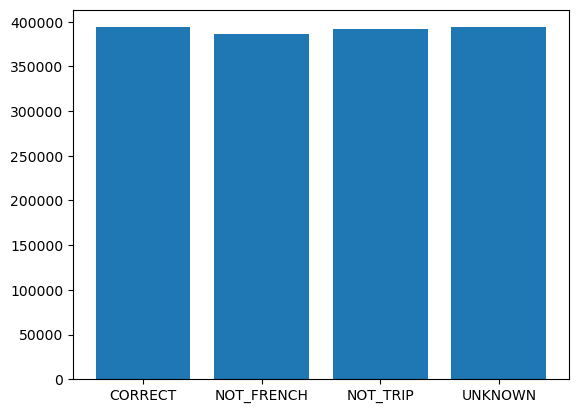

In [4]:
dataset = flatten_trips_labels(dataset)

show_labels_distribution(dataset, labels)

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(dataset, labels, final_dataset_size=0.9)

In [6]:
X_train.values

array(['mdfylmovsvm gc jnjpe tzbu ',
       'Aller de la place centrale de Hazebrouck à la place centrale de Vorey.',
       'Head towards ST-JEAN-DE-BASSEL-EGLIS from another city.', ...,
       "J'aimerais aller à la place centrale de Dijon en partant de la place centrale de Saint-Julien-Les-Villas.",
       ' p  ox va  gsyl p  ghykouv',
       "I'm looking for a way to arrive at ventimiglia-stazione."],
      dtype=object)

# Utilisation d'un pipeline SKLearn (vectorizer + classifier LogisticRegression avec OneVsRestClassifier pour la classification multi-label)

In [7]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

pipeline = create_pipeline(
    CountVectorizer(ngram_range=(1, 2)),
    CalibratedClassifierCV(LinearSVC(tol=1e-2, max_iter=1000), method='sigmoid', cv=5)
)

# evaluate_model_kfold_with_predictions(pipeline, dataset, labels, id2label)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 OneVsRestClassifier(estimator=CalibratedClassifierCV(cv=5,
                                                                      estimator=LinearSVC(tol=0.01))))])

# Evaluation du modèle, métriques

In [8]:
y_pred = pipeline.predict(X_test)

show_classification_report(y_pred, y_test, labels)

Classification Report for 
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      2303
  NOT_FRENCH       1.00      0.90      0.95      2229
    NOT_TRIP       1.00      0.94      0.97      2211
     UNKNOWN       0.98      0.99      0.98      2189

   micro avg       0.99      0.96      0.97      8932
   macro avg       0.99      0.96      0.97      8932
weighted avg       0.99      0.96      0.97      8932
 samples avg       0.98      0.97      0.97      8932


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# On observe ici que le modèle semble performant, avec malgré tout une petit faiblesse du recall pour les classes NOT_FRENCH et NOT_TRIP

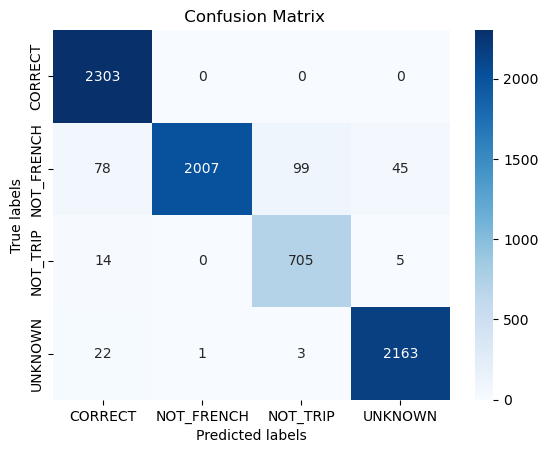

In [9]:
show_confusion_matrix(y_pred, y_test, labels)

# La matrice de confusion vient confirmer les très bons résultats observés précedemment

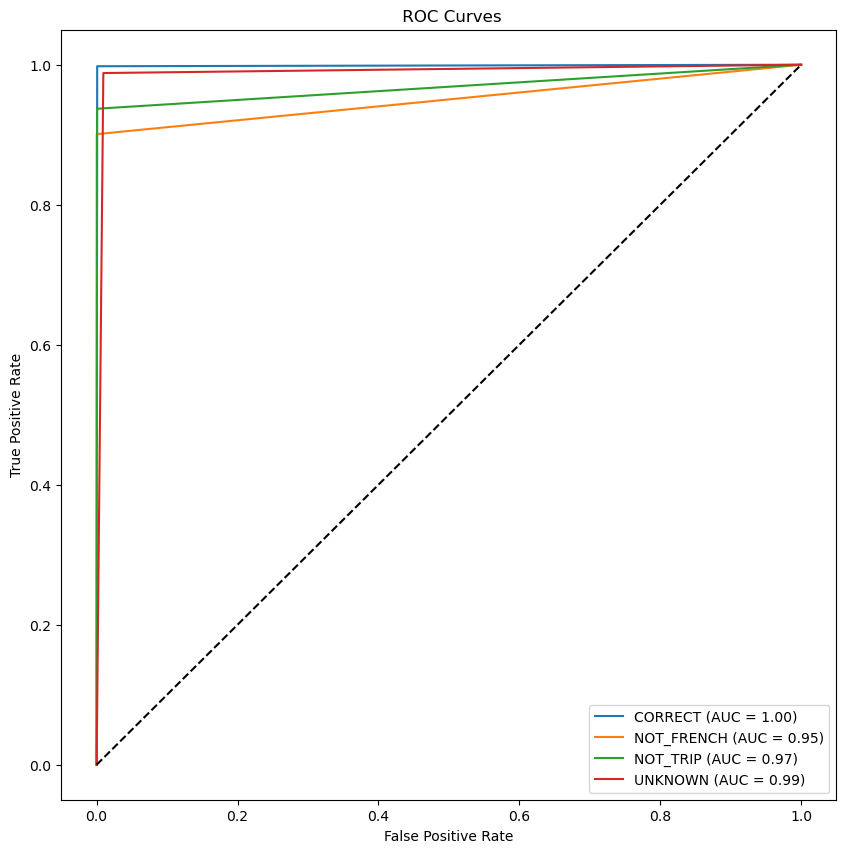

In [10]:
show_roc_curves(labels, y_pred, y_test)

In [11]:
show_samples_predictions(pipeline, id2label)

* Je veux aller de Port-Boulet à Le Havre.
 - CORRECT => 98.7%
 - NOT_FRENCH => 4.8%
 - NOT_TRIP => 21.5%
 - UNKNOWN => 0.0%

* Je veux aller de Port-Boulet au Havre.
 - CORRECT => 91.0%
 - NOT_FRENCH => 2.4%
 - NOT_TRIP => 14.6%
 - UNKNOWN => 0.0%

* Je vais de Nantes à Paris.
 - CORRECT => 99.6%
 - NOT_FRENCH => 7.8%
 - NOT_TRIP => 15.6%
 - UNKNOWN => 0.0%

* Je vais de Nantes à Nantes.
 - CORRECT => 99.7%
 - NOT_FRENCH => 5.9%
 - NOT_TRIP => 14.9%
 - UNKNOWN => 0.0%

* Je veux aller de Nantes à Nantes.
 - CORRECT => 99.8%
 - NOT_FRENCH => 3.4%
 - NOT_TRIP => 14.4%
 - UNKNOWN => 0.0%

* Je vais à Port-Boulet en partant de Le Havre
 - CORRECT => 100.0%
 - NOT_FRENCH => 5.2%
 - NOT_TRIP => 7.0%
 - UNKNOWN => 0.0%

* Je vais à Port-Boulet en partant du Havre
 - CORRECT => 93.6%
 - NOT_FRENCH => 8.9%
 - NOT_TRIP => 11.9%
 - UNKNOWN => 0.0%

* Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?
 - CORRECT => 100.0%
 - NOT_FRENCH => 4.0%
 - NOT_TRIP => 3.9%
 - UNKNOWN =>

### On peut observer des résultats cohérents sur ces phrases inconnues du dataset, hormis la mauvaise gestion de la duplication du nom de ville, qui induit le modèle en erreur

In [12]:
import pickle

with open('model/tf_idf_linear_svc_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

### Le classifieur obtient de bons résultats, même en comparaison avec le panel testé lors du benchmark. On réalise donc la sauvegarde du modèle afin de l'utiliser dans le cadre du projet.